# 0. 코드 설명

# 1. 라이브러리 가져오기

In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing


import matplotlib.pyplot as plt


# 2. 데이터 불러오기

In [3]:
feature_df = pd.read_csv("../../data/processed/feature_data.csv")
print(feature_df.shape)
feature_df.head()

(32048, 49)


,X_ActualPosition,X_ActualVelocity,X_ActualAcceleration,X_SetPosition,X_SetVelocity,X_SetAcceleration,X_CurrentFeedback,X_DCBusVoltage,X_OutputCurrent,X_OutputVoltage,...,S_SystemInertia,M_CURRENT_PROGRAM_NUMBER,M_sequence_number,M_CURRENT_FEEDRATE,Machining_Process,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,202.0,4.0,4.00,202.0,4.0,4.000000,0.18,0.0207,329,2.77,...,16.0,1,0,50,7,6,4.0,0,1,1
1,202.0,-6.8,-346.00,202.0,-9.6,-354.000000,-10.90,0.1860,328,23.30,...,16.0,1,4,50,7,6,4.0,0,1,1
2,200.0,-13.8,-2.25,200.0,-13.9,3.999905,-8.59,0.1400,328,30.60,...,16.0,1,7,50,7,6,4.0,0,1,1
3,198.0,-14.0,4.00,198.0,-13.9,3.999905,-6.11,0.1300,327,30.30,...,16.0,1,7,50,7,6,4.0,0,1,1
4,197.0,-13.9,-14.80,196.0,-13.9,4.000095,-5.70,0.1140,328,30.50,...,16.0,1,7,50,7,6,4.0,0,1,1


In [4]:
train, test = train_test_split(feature_df, test_size=0.2, random_state=0)
train, val = train_test_split(train, test_size=0.2, random_state=0)
print(len(train), '훈련 샘플')
print(len(val), '검증 샘플')
print(len(test), '테스트 샘플')

20510 훈련 샘플
5128 검증 샘플
6410 테스트 샘플


# 3. Modeling
* Tensorflow Dataset 사용
* Keras preprocessing layer 사용

### 사용자 정의 함수

In [5]:
# Pandas DataFrame ==> Tensorflow Dataset
def df_to_dataset(dataframe, target, shuffle=True, batch_size=32):
    targets = ['tool_condition', 'machining_finalized', 'passed_visual_inspection']
    dataframe = dataframe.copy()# ==> 총 열의 길이 x features) tensor, 2D
    targets.remove(target)
    dataframe.drop(targets, axis=1, inplace=True) # 원하는 target만 남기고 다 제거
    labels = dataframe.pop(target) # ==> (총 열의 길이 x 1) tensor, 2D
    
    # dict(dataframe) ==> 특징을 key로 하고, 그 특징의 행을 value로 하는 Dictionary 데이터를 만듦.
    # 데이터가 특성과 라벨로 나누어져 있다면, 한 개 이상의 데이터를 넣을 수 있고, 서로 묶어서 데이터 셋을 만듦
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe)) # training을 시작 할 때, 전부 버퍼에 가져옴
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [6]:
# Keras Preprocessing Layer 사용

# name => 처리 할 특징 이름, dataset => 데이터 셋
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    # 특성의 평균 및 표준 편차를 보유할 수 있는 레이어.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    # Map 함수는 입력 데이터셋의 각 원소에 주어진 함수 f를 적용하여 새로운 데이터셋을 생성해줌.
    # lambda ==> 일시적으로 사용하고 버리는 함수
    # lambda x, y: x[name] => x, y는 파라미터, x[name]은 리턴 값. 내 데이터셋은 feature와 라벨로 구성되어 있어서 두 개의 파라미터가 필요?
    # 원하는 한 행 뗴어온다고 생각하면 됨.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)
    
    # 이제 이 레이어에 한 행을 집어넣으면, 평균과 분산이 0과 1이 되어서 나옴.
    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # 문자열을 정수로 바꿔주는 StringLookup 레이어, dict 조회를 통해 정수 입력을 연속 범위에 있도록 다시 인덱싱하는 IntegerLookup 레이어.
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_values=max_tokens)

    # Prepare a Dataset that only yields our feature
    # 원하는 한 행 떼어옴
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Create a Discretization for our integer indices.
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    # Prepare a Dataset that only yields our feature.
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices.
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices. The lambda function captures the
    # layer so we can use them, or include them in the functional model later.
    return lambda feature: encoder(index(feature))

## Case1 : Tool Condition

In [7]:
batch_size = 128
target = 'tool_condition'
train_ds = df_to_dataset(train, target, batch_size=batch_size)
val_ds = df_to_dataset(val, target, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, target, shuffle=False, batch_size=batch_size)

In [8]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of tool_condition:', label_batch )

Every feature: ['X_ActualPosition', 'X_ActualVelocity', 'X_ActualAcceleration', 'X_SetPosition', 'X_SetVelocity', 'X_SetAcceleration', 'X_CurrentFeedback', 'X_DCBusVoltage', 'X_OutputCurrent', 'X_OutputVoltage', 'X_OutputPower', 'Y_ActualPosition', 'Y_ActualVelocity', 'Y_ActualAcceleration', 'Y_SetPosition', 'Y_SetVelocity', 'Y_SetAcceleration', 'Y_CurrentFeedback', 'Y_DCBusVoltage', 'Y_OutputCurrent', 'Y_OutputVoltage', 'Y_OutputPower', 'Z_ActualPosition', 'Z_ActualVelocity', 'Z_ActualAcceleration', 'Z_SetPosition', 'Z_SetVelocity', 'Z_SetAcceleration', 'S_ActualPosition', 'S_ActualVelocity', 'S_ActualAcceleration', 'S_SetPosition', 'S_SetVelocity', 'S_SetAcceleration', 'S_CurrentFeedback', 'S_DCBusVoltage', 'S_OutputCurrent', 'S_OutputVoltage', 'S_OutputPower', 'S_SystemInertia', 'M_CURRENT_PROGRAM_NUMBER', 'M_sequence_number', 'M_CURRENT_FEEDRATE', 'Machining_Process', 'feedrate', 'clamp_pressure']
A batch of tool_condition: tf.Tensor(
[1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 

In [9]:
# 정규화 및 문자열 인덱스화 할 수 있게 미리 구조화 할 수 있게 해주는 코드
# 이렇게 해두면 나중에 모델에서 자동으로 전처리 해줌.

all_inputs = []
encoded_features = []

numerical_cols = list(train_features.keys())
categorical_cols = ['Machining_Process','M_sequence_number','M_CURRENT_PROGRAM_NUMBER']
for feature in categorical_cols :
    numerical_cols.remove(feature)
    
# Categorical features encoded as string.
for header in categorical_cols:
    # 진행상태 확인을 위해
    print(header)
    # Input() ==> Keras Tensor를 인스턴스화 하는데 사용
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64')
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)
    
# Numeric features.
for header in numerical_cols:
    # 진행상태 확인을 위해
    print(header)
    # Input() ==> Keras Tensor를 인스턴스화 하는데 사용
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    # 정규화 할 수 있는 레이어를 얻음.
    normalization_layer = get_normalization_layer(header, train_ds)
    # 정규화 한 행을 얻을 수 있는 변수?
    encoded_numeric_col = normalization_layer(numeric_col)
    # Keras.Input이 들어감
    all_inputs.append(numeric_col)
    # 정규화한 행이 들어감.
    encoded_features.append(encoded_numeric_col)

Machining_Process
M_sequence_number
M_CURRENT_PROGRAM_NUMBER
X_ActualPosition
X_ActualVelocity
X_ActualAcceleration
X_SetPosition
X_SetVelocity
X_SetAcceleration
X_CurrentFeedback
X_DCBusVoltage
X_OutputCurrent
X_OutputVoltage
X_OutputPower
Y_ActualPosition
Y_ActualVelocity
Y_ActualAcceleration
Y_SetPosition
Y_SetVelocity
Y_SetAcceleration
Y_CurrentFeedback
Y_DCBusVoltage
Y_OutputCurrent
Y_OutputVoltage
Y_OutputPower
Z_ActualPosition
Z_ActualVelocity
Z_ActualAcceleration
Z_SetPosition
Z_SetVelocity
Z_SetAcceleration
S_ActualPosition
S_ActualVelocity
S_ActualAcceleration
S_SetPosition
S_SetVelocity
S_SetAcceleration
S_CurrentFeedback
S_DCBusVoltage
S_OutputCurrent
S_OutputVoltage
S_OutputPower
S_SystemInertia
M_CURRENT_FEEDRATE
feedrate
clamp_pressure


In [10]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(512, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation="sigmoid")(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [11]:
model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
161/161 [==============================] - 4s 23ms/step - loss: 0.4045 - accuracy: 0.7833 - val_loss: 0.2694 - val_accuracy: 0.8491
Epoch 2/15
161/161 [==============================] - 3s 19ms/step - loss: 0.2420 - accuracy: 0.8635 - val_loss: 0.1989 - val_accuracy: 0.8888
Epoch 3/15
161/161 [==============================] - 3s 19ms/step - loss: 0.2067 - accuracy: 0.8838 - val_loss: 0.1789 - val_accuracy: 0.9037
Epoch 4/15
161/161 [==============================] - 3s 19ms/step - loss: 0.1908 - accuracy: 0.8946 - val_loss: 0.1719 - val_accuracy: 0.9035
Epoch 5/15
161/161 [==============================] - 3s 18ms/step - loss: 0.1719 - accuracy: 0.9076 - val_loss: 0.1506 - val_accuracy: 0.9160
Epoch 6/15
161/161 [==============================] - 3s 19ms/step - loss: 0.1638 - accuracy: 0.9118 - val_loss: 0.1455 - val_accuracy: 0.9167
Epoch 7/15
161/161 [==============================] - 3s 19ms/step - loss: 0.1488 - accuracy: 0.9172 - val_loss: 0.1447 - val_accuracy: 0.9142

In [13]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

51/51 [==============================] - 0s 5ms/step - loss: 0.1417 - accuracy: 0.9181
Accuracy 0.9180967211723328


## Case2 : Machining Finalized

In [14]:
batch_size = 128
target = 'machining_finalized'
train_ds = df_to_dataset(train, target, batch_size=batch_size)
val_ds = df_to_dataset(val, target, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, target, shuffle=False, batch_size=batch_size)

In [15]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of machining_finalized:', label_batch )

Every feature: ['X_ActualPosition', 'X_ActualVelocity', 'X_ActualAcceleration', 'X_SetPosition', 'X_SetVelocity', 'X_SetAcceleration', 'X_CurrentFeedback', 'X_DCBusVoltage', 'X_OutputCurrent', 'X_OutputVoltage', 'X_OutputPower', 'Y_ActualPosition', 'Y_ActualVelocity', 'Y_ActualAcceleration', 'Y_SetPosition', 'Y_SetVelocity', 'Y_SetAcceleration', 'Y_CurrentFeedback', 'Y_DCBusVoltage', 'Y_OutputCurrent', 'Y_OutputVoltage', 'Y_OutputPower', 'Z_ActualPosition', 'Z_ActualVelocity', 'Z_ActualAcceleration', 'Z_SetPosition', 'Z_SetVelocity', 'Z_SetAcceleration', 'S_ActualPosition', 'S_ActualVelocity', 'S_ActualAcceleration', 'S_SetPosition', 'S_SetVelocity', 'S_SetAcceleration', 'S_CurrentFeedback', 'S_DCBusVoltage', 'S_OutputCurrent', 'S_OutputVoltage', 'S_OutputPower', 'S_SystemInertia', 'M_CURRENT_PROGRAM_NUMBER', 'M_sequence_number', 'M_CURRENT_FEEDRATE', 'Machining_Process', 'feedrate', 'clamp_pressure']
A batch of machining_finalized: tf.Tensor(
[1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1

In [16]:
# 정규화 및 문자열 인덱스화 할 수 있게 미리 구조화 할 수 있게 해주는 코드
# 이렇게 해두면 나중에 모델에서 자동으로 전처리 해줌.

all_inputs = []
encoded_features = []

numerical_cols = list(train_features.keys())
categorical_cols = ['Machining_Process','M_sequence_number','M_CURRENT_PROGRAM_NUMBER']
for feature in categorical_cols :
    numerical_cols.remove(feature)
    
# Categorical features encoded as string.
for header in categorical_cols:
    # 진행상태 확인을 위해
    print(header)
    # Input() ==> Keras Tensor를 인스턴스화 하는데 사용
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64')
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)
    
# Numeric features.
for header in numerical_cols:
    # 진행상태 확인을 위해
    print(header)
    # Input() ==> Keras Tensor를 인스턴스화 하는데 사용
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    # 정규화 할 수 있는 레이어를 얻음.
    normalization_layer = get_normalization_layer(header, train_ds)
    # 정규화 한 행을 얻을 수 있는 변수?
    encoded_numeric_col = normalization_layer(numeric_col)
    # Keras.Input이 들어감
    all_inputs.append(numeric_col)
    # 정규화한 행이 들어감.
    encoded_features.append(encoded_numeric_col)

Machining_Process
M_sequence_number
M_CURRENT_PROGRAM_NUMBER
X_ActualPosition
X_ActualVelocity
X_ActualAcceleration
X_SetPosition
X_SetVelocity
X_SetAcceleration
X_CurrentFeedback
X_DCBusVoltage
X_OutputCurrent
X_OutputVoltage
X_OutputPower
Y_ActualPosition
Y_ActualVelocity
Y_ActualAcceleration
Y_SetPosition
Y_SetVelocity
Y_SetAcceleration
Y_CurrentFeedback
Y_DCBusVoltage
Y_OutputCurrent
Y_OutputVoltage
Y_OutputPower
Z_ActualPosition
Z_ActualVelocity
Z_ActualAcceleration
Z_SetPosition
Z_SetVelocity
Z_SetAcceleration
S_ActualPosition
S_ActualVelocity
S_ActualAcceleration
S_SetPosition
S_SetVelocity
S_SetAcceleration
S_CurrentFeedback
S_DCBusVoltage
S_OutputCurrent
S_OutputVoltage
S_OutputPower
S_SystemInertia
M_CURRENT_FEEDRATE
feedrate
clamp_pressure


In [17]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(512, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation="sigmoid")(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [18]:
model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
161/161 [==============================] - 4s 23ms/step - loss: 0.1756 - accuracy: 0.9202 - val_loss: 0.0928 - val_accuracy: 0.9598
Epoch 2/15
161/161 [==============================] - 3s 18ms/step - loss: 0.0860 - accuracy: 0.9585 - val_loss: 0.0655 - val_accuracy: 0.9604
Epoch 3/15
161/161 [==============================] - 3s 18ms/step - loss: 0.0558 - accuracy: 0.9748 - val_loss: 0.0416 - val_accuracy: 0.9834
Epoch 4/15
161/161 [==============================] - 3s 19ms/step - loss: 0.0380 - accuracy: 0.9843 - val_loss: 0.0411 - val_accuracy: 0.9862
Epoch 5/15
161/161 [==============================] - 3s 19ms/step - loss: 0.0289 - accuracy: 0.9884 - val_loss: 0.0284 - val_accuracy: 0.9879
Epoch 6/15
161/161 [==============================] - 3s 19ms/step - loss: 0.0212 - accuracy: 0.9916 - val_loss: 0.0317 - val_accuracy: 0.9875
Epoch 7/15
161/161 [==============================] - 3s 18ms/step - loss: 0.0168 - accuracy: 0.9937 - val_loss: 0.0215 - val_accuracy: 0.9906

In [19]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

51/51 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 0.9953
Accuracy 0.9953197836875916


## Case3 : Passed Visual Inspection

In [20]:
batch_size = 128
target = 'passed_visual_inspection'
train_ds = df_to_dataset(train, target, batch_size=batch_size)
val_ds = df_to_dataset(val, target, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, target, shuffle=False, batch_size=batch_size)

In [21]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of passed_visual_inspection:', label_batch )

Every feature: ['X_ActualPosition', 'X_ActualVelocity', 'X_ActualAcceleration', 'X_SetPosition', 'X_SetVelocity', 'X_SetAcceleration', 'X_CurrentFeedback', 'X_DCBusVoltage', 'X_OutputCurrent', 'X_OutputVoltage', 'X_OutputPower', 'Y_ActualPosition', 'Y_ActualVelocity', 'Y_ActualAcceleration', 'Y_SetPosition', 'Y_SetVelocity', 'Y_SetAcceleration', 'Y_CurrentFeedback', 'Y_DCBusVoltage', 'Y_OutputCurrent', 'Y_OutputVoltage', 'Y_OutputPower', 'Z_ActualPosition', 'Z_ActualVelocity', 'Z_ActualAcceleration', 'Z_SetPosition', 'Z_SetVelocity', 'Z_SetAcceleration', 'S_ActualPosition', 'S_ActualVelocity', 'S_ActualAcceleration', 'S_SetPosition', 'S_SetVelocity', 'S_SetAcceleration', 'S_CurrentFeedback', 'S_DCBusVoltage', 'S_OutputCurrent', 'S_OutputVoltage', 'S_OutputPower', 'S_SystemInertia', 'M_CURRENT_PROGRAM_NUMBER', 'M_sequence_number', 'M_CURRENT_FEEDRATE', 'Machining_Process', 'feedrate', 'clamp_pressure']
A batch of passed_visual_inspection: tf.Tensor(
[1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 

In [22]:
# 정규화 및 문자열 인덱스화 할 수 있게 미리 구조화 할 수 있게 해주는 코드
# 이렇게 해두면 나중에 모델에서 자동으로 전처리 해줌.

all_inputs = []
encoded_features = []

numerical_cols = list(train_features.keys())
categorical_cols = ['Machining_Process','M_sequence_number','M_CURRENT_PROGRAM_NUMBER']
for feature in categorical_cols :
    numerical_cols.remove(feature)
    
# Categorical features encoded as string.
for header in categorical_cols:
    # 진행상태 확인을 위해
    print(header)
    # Input() ==> Keras Tensor를 인스턴스화 하는데 사용
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64')
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)
    
# Numeric features.
for header in numerical_cols:
    # 진행상태 확인을 위해
    print(header)
    # Input() ==> Keras Tensor를 인스턴스화 하는데 사용
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    # 정규화 할 수 있는 레이어를 얻음.
    normalization_layer = get_normalization_layer(header, train_ds)
    # 정규화 한 행을 얻을 수 있는 변수?
    encoded_numeric_col = normalization_layer(numeric_col)
    # Keras.Input이 들어감
    all_inputs.append(numeric_col)
    # 정규화한 행이 들어감.
    encoded_features.append(encoded_numeric_col)

Machining_Process
M_sequence_number
M_CURRENT_PROGRAM_NUMBER
X_ActualPosition
X_ActualVelocity
X_ActualAcceleration
X_SetPosition
X_SetVelocity
X_SetAcceleration
X_CurrentFeedback
X_DCBusVoltage
X_OutputCurrent
X_OutputVoltage
X_OutputPower
Y_ActualPosition
Y_ActualVelocity
Y_ActualAcceleration
Y_SetPosition
Y_SetVelocity
Y_SetAcceleration
Y_CurrentFeedback
Y_DCBusVoltage
Y_OutputCurrent
Y_OutputVoltage
Y_OutputPower
Z_ActualPosition
Z_ActualVelocity
Z_ActualAcceleration
Z_SetPosition
Z_SetVelocity
Z_SetAcceleration
S_ActualPosition
S_ActualVelocity
S_ActualAcceleration
S_SetPosition
S_SetVelocity
S_SetAcceleration
S_CurrentFeedback
S_DCBusVoltage
S_OutputCurrent
S_OutputVoltage
S_OutputPower
S_SystemInertia
M_CURRENT_FEEDRATE
feedrate
clamp_pressure


In [23]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(512, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation="sigmoid")(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [24]:
model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
161/161 [==============================] - 4s 22ms/step - loss: 0.2130 - accuracy: 0.9011 - val_loss: 0.0834 - val_accuracy: 0.9526
Epoch 2/15
161/161 [==============================] - 3s 18ms/step - loss: 0.0883 - accuracy: 0.9608 - val_loss: 0.0483 - val_accuracy: 0.9813
Epoch 3/15
161/161 [==============================] - 3s 19ms/step - loss: 0.0597 - accuracy: 0.9755 - val_loss: 0.0339 - val_accuracy: 0.9844
Epoch 4/15
161/161 [==============================] - 3s 18ms/step - loss: 0.0399 - accuracy: 0.9833 - val_loss: 0.0328 - val_accuracy: 0.9899
Epoch 5/15
161/161 [==============================] - 3s 18ms/step - loss: 0.0292 - accuracy: 0.9884 - val_loss: 0.0213 - val_accuracy: 0.9922
Epoch 6/15
161/161 [==============================] - 3s 18ms/step - loss: 0.0248 - accuracy: 0.9909 - val_loss: 0.0228 - val_accuracy: 0.9910
Epoch 7/15
161/161 [==============================] - 3s 18ms/step - loss: 0.0191 - accuracy: 0.9931 - val_loss: 0.0190 - val_accuracy: 0.9932

In [25]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

51/51 [==============================] - 0s 5ms/step - loss: 0.0102 - accuracy: 0.9970
Accuracy 0.9970358610153198


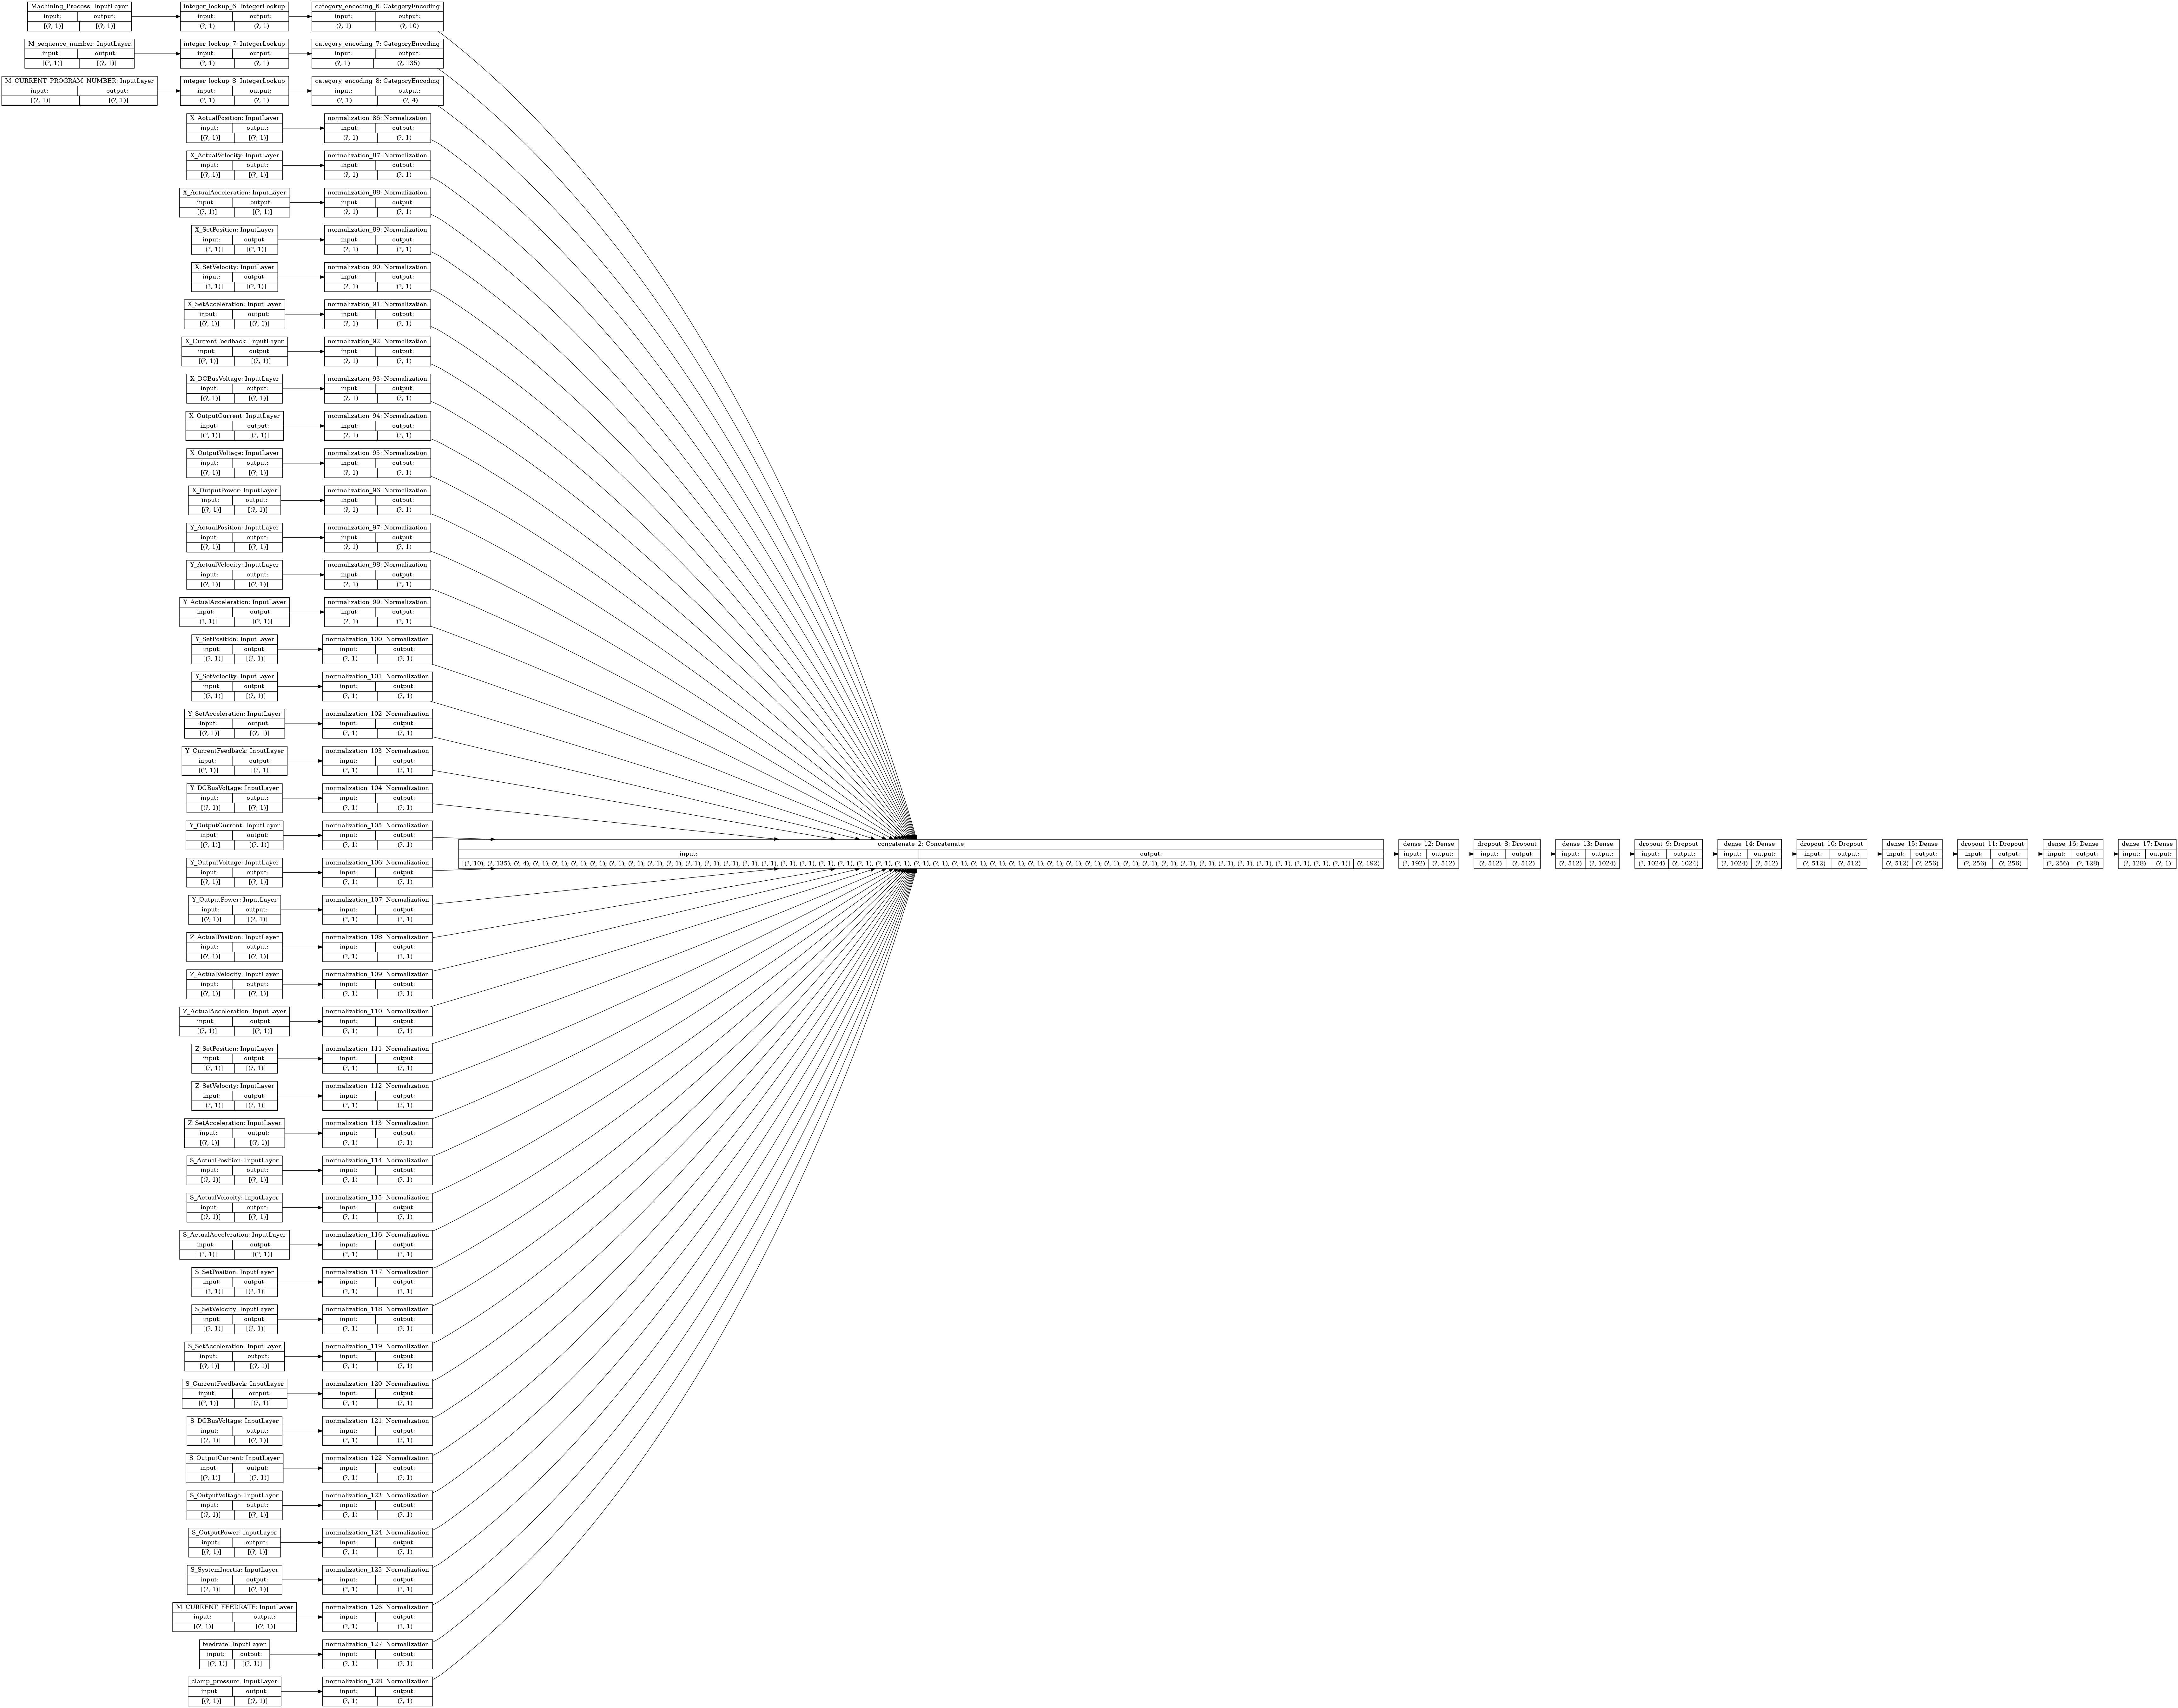

In [26]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")